In [1]:
input_dim = 13166
model_file = "Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt"
num_clusters = 4
pc_matrix_file = "Data/bipolar_pc.tsv"

import json
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
import os
import pandas as pd
import scipy
import tensorflow as tf

from load_vae import load_vae

import sys
sys.path.insert(0, "../Code/")
from explain_sync import explain, apply
from metrics import metrics

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file, feature_transform = pc_matrix_file)


In [2]:
###
# Load Data & Configuration
###

x = pd.read_csv("Data/bipolar_rep_scaled.tsv", sep="\t").values

with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [3]:
###
# Approximate the original data
###

matrix = pd.read_csv(pc_matrix_file, sep = "\t", header = None).values

x_full = np.matmul(x, np.transpose(matrix))

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


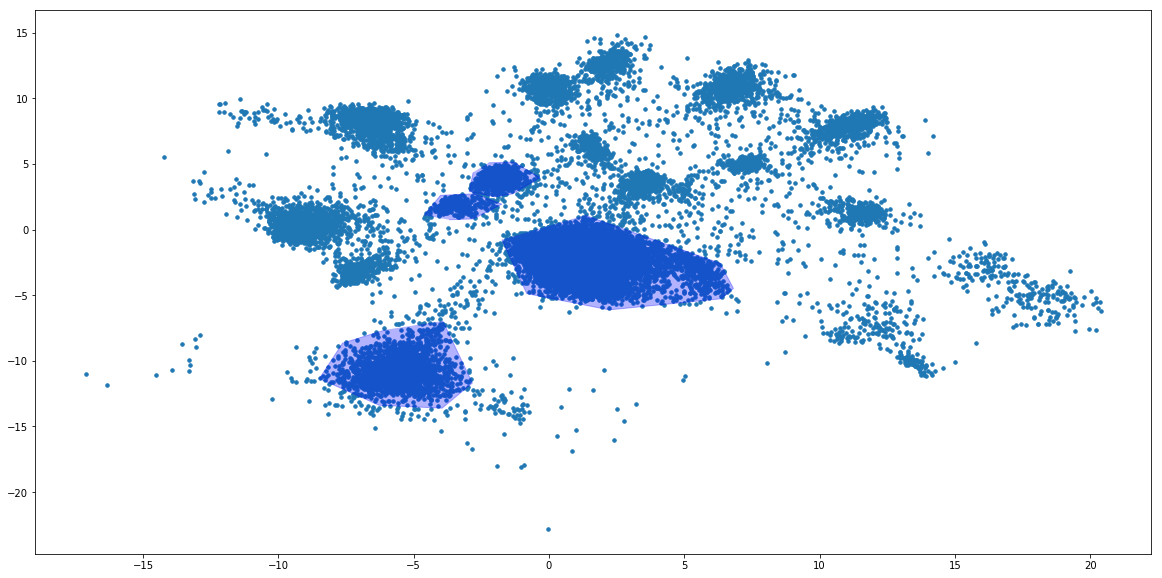

In [4]:
###
# Visualize the data and the marked clusters
###

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x_full, D: np.zeros((1, input_dim))})

fig, ax = plt.subplots(figsize=(20, 10))
patches = []

for i in range(num_clusters):
    line = plt.Polygon(all_vertices[i], closed=False, color="blue", alpha=0.3)
    ax.add_line(line)

plt.scatter(data_rep[:, 0], data_rep[:, 1], s = 12)

plt.show()
plt.close()

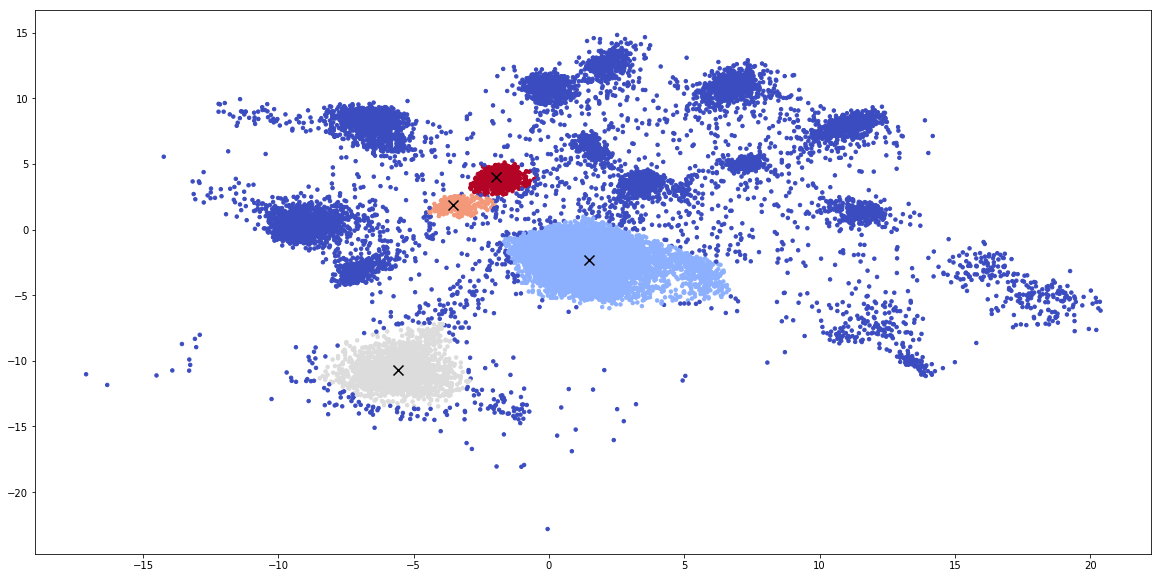

In [5]:
###
# Find the datapoints in each marked cluster
###

m = data_rep.shape[0]
cluster = -1.0 * np.ones((m))
indices = [[]] * num_clusters
centers = [[]] * num_clusters
for i in range(num_clusters):
    path = Path(all_vertices[i])
    indices[i] = []
    for j in range(m):
        if path.contains_points(data_rep[j].reshape((1,2))):
            cluster[j] = i
            indices[i].append(j)
    centers[i] = np.mean(data_rep[indices[i], :], axis = 0)
    
centers = np.array(centers)

fig, ax = plt.subplots(figsize=(20, 10))
patches = []
    
plt.scatter(data_rep[:, 0], data_rep[:, 1], s = 12, c = cluster, cmap = plt.cm.coolwarm)
plt.scatter(centers[:, 0], centers[:, 1], c = "black", marker = "x", s = 100)

plt.show()
plt.close()   

In [6]:
###
# Set epsilon for our metrics
###

epsilon = 0.25

a, b = metrics(load_model, x_full, indices, np.zeros((num_clusters - 1, input_dim)), epsilon)

print(a)
print(b)

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
[[0.99944253 0.         0.         0.        ]
 [0.         0.99391069 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.999243  ]]
[[0.99944253 0.         0.         0.        ]
 [0.         0.99391069 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.999243  ]]


In [7]:
###
# Compute the cluster explanations
###

lambda_init = 40000.0
factor = 1.1
threshold = 0.80

while True:
    os.system("rm -rf explanation")
    deltas = explain(load_model, x_full, data_rep, indices, lambda_global = lambda_init)
    
    a, b = metrics(load_model, x_full, indices, deltas, epsilon)
    print(lambda_init)
    print(a)
    print(b)
    
    score = (np.sum(a) - num_clusters) / (num_clusters * num_clusters - num_clusters)
    print(score)
    if score < threshold:
        break
    else:
        lambda_init *= factor


INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
40000.0
[[0.99944253 0.99860634 0.85998328 0.9334758 ]
 [0.84167794 0.99391069 0.21008119 0.69384303]
 [0.98526316 1.         1.         0.69473684]
 [0.90915973 1.         0.54125662 0.999243  ]]
[[0.99944253 0.44113667 1.         1.        ]
 [0.96822447 0.99391069 1.         1.        ]
 [0.70835269 0.30818674 1.         0.84481453]
 [0.77989408 0.38024357 0.99578947 0.999243  ]]
0.8050566790058006
INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from Model/model/perplexity_10


From  0  to  1 

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


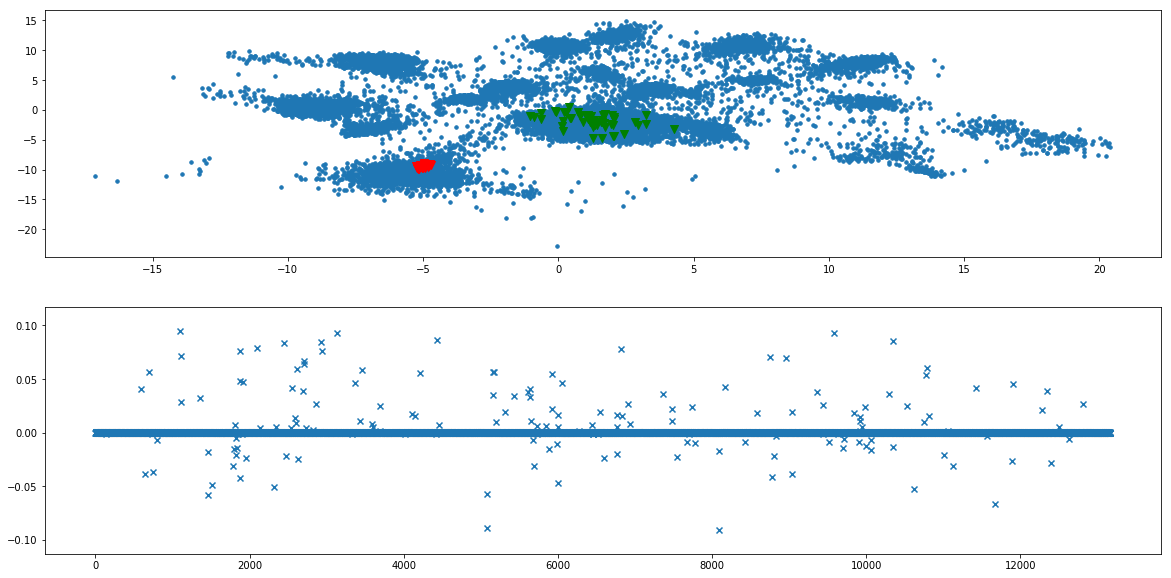


From  1  to  0 

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


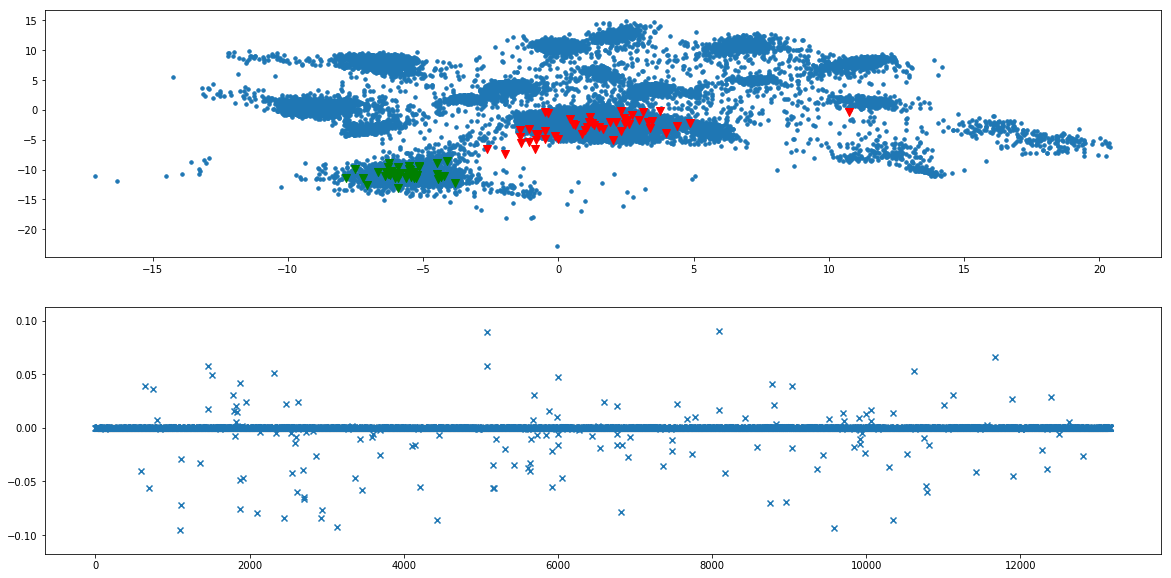


From  0  to  2 

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


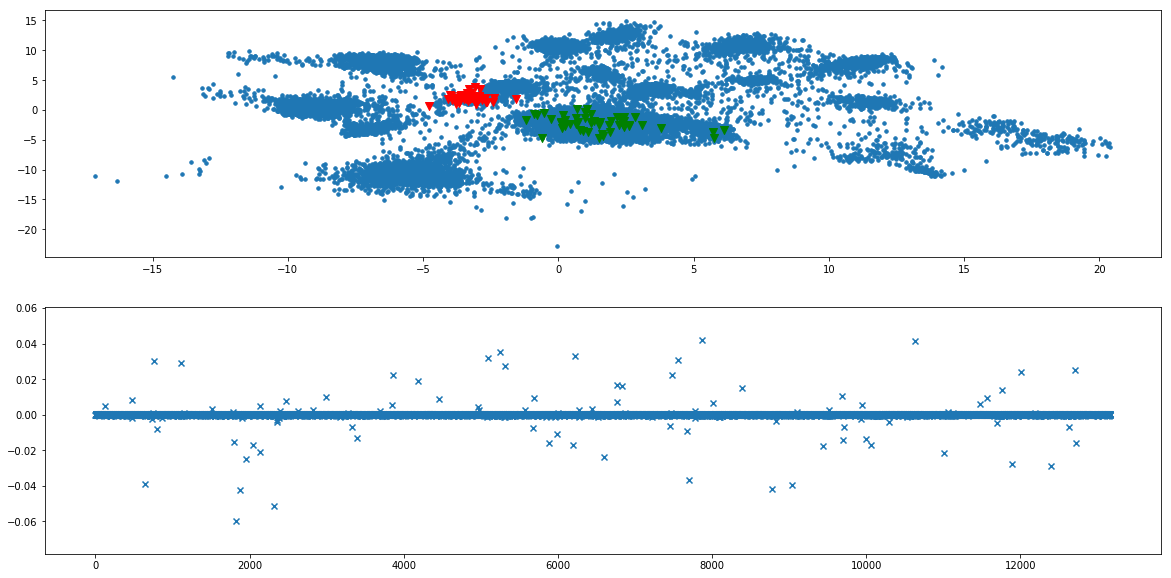


From  2  to  0 

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


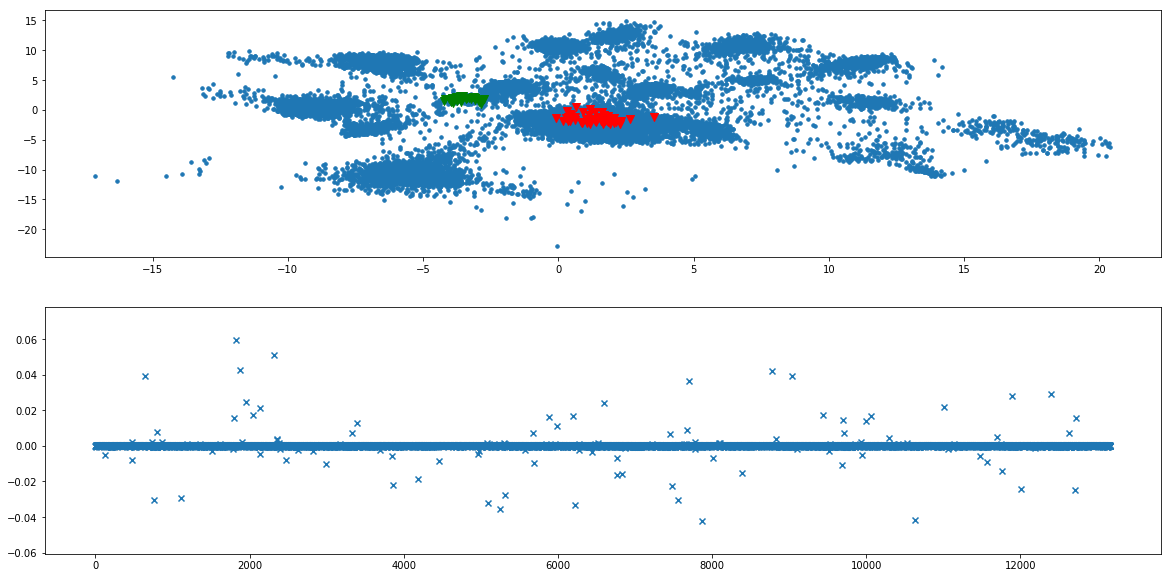


From  1  to  2 

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


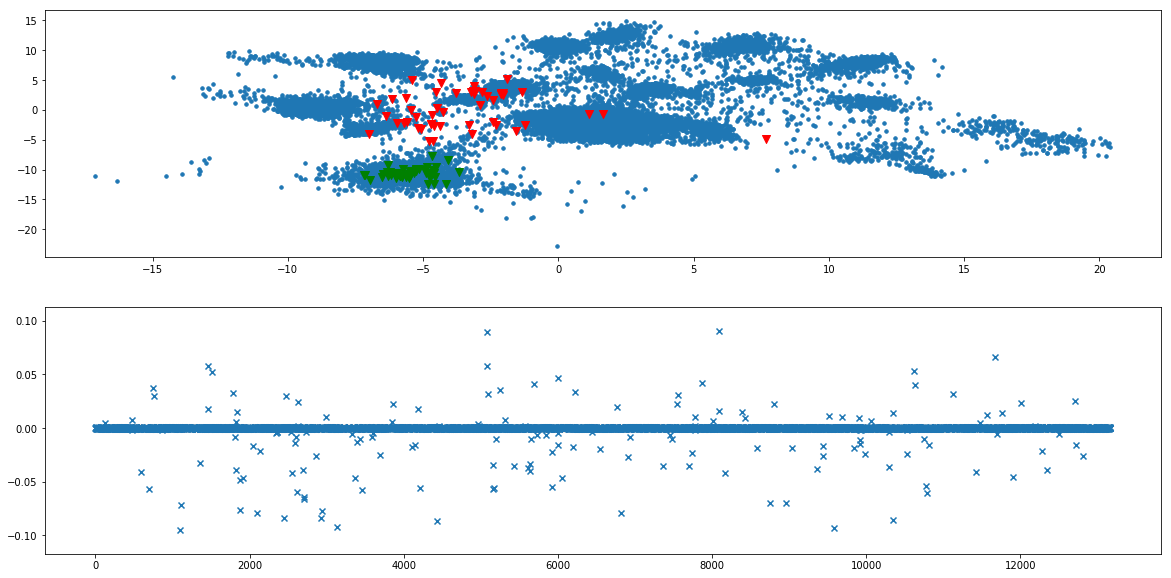


From  2  to  1 

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


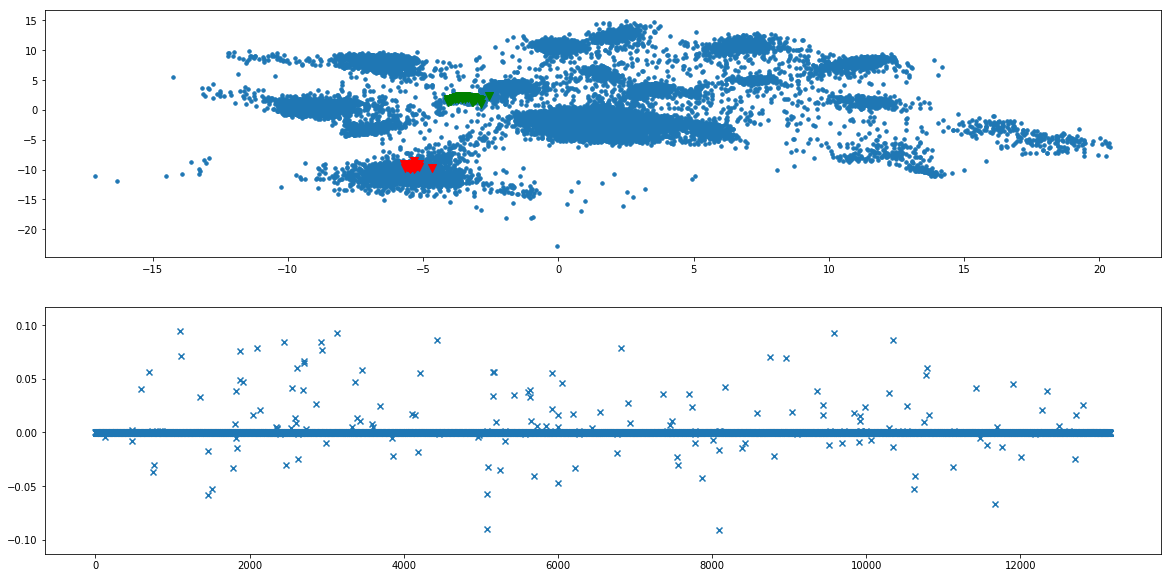


From  0  to  3 

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


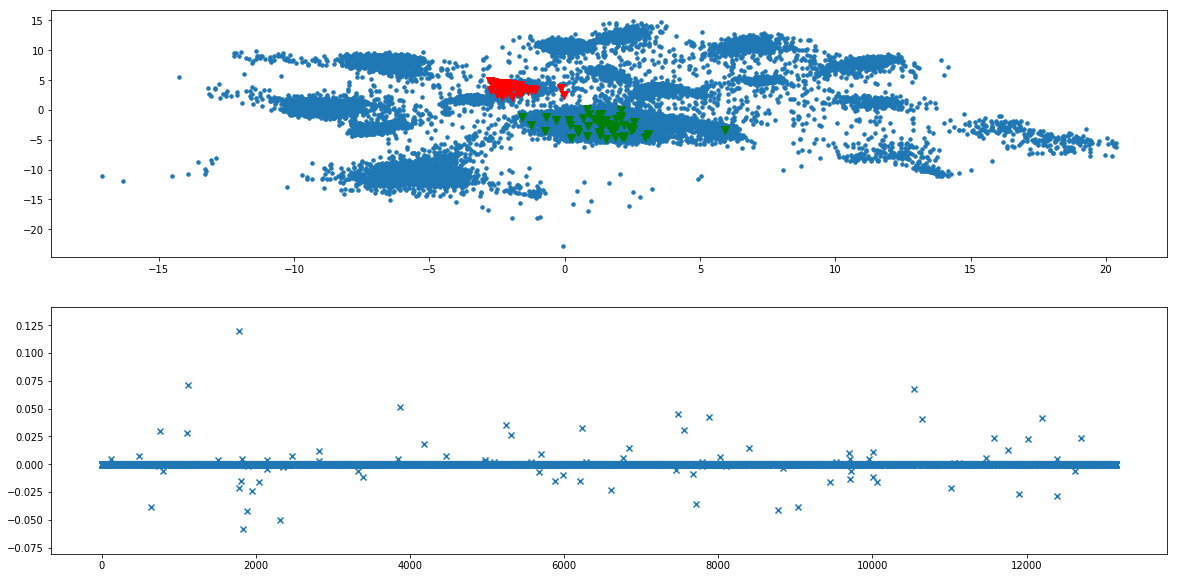


From  3  to  0 

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


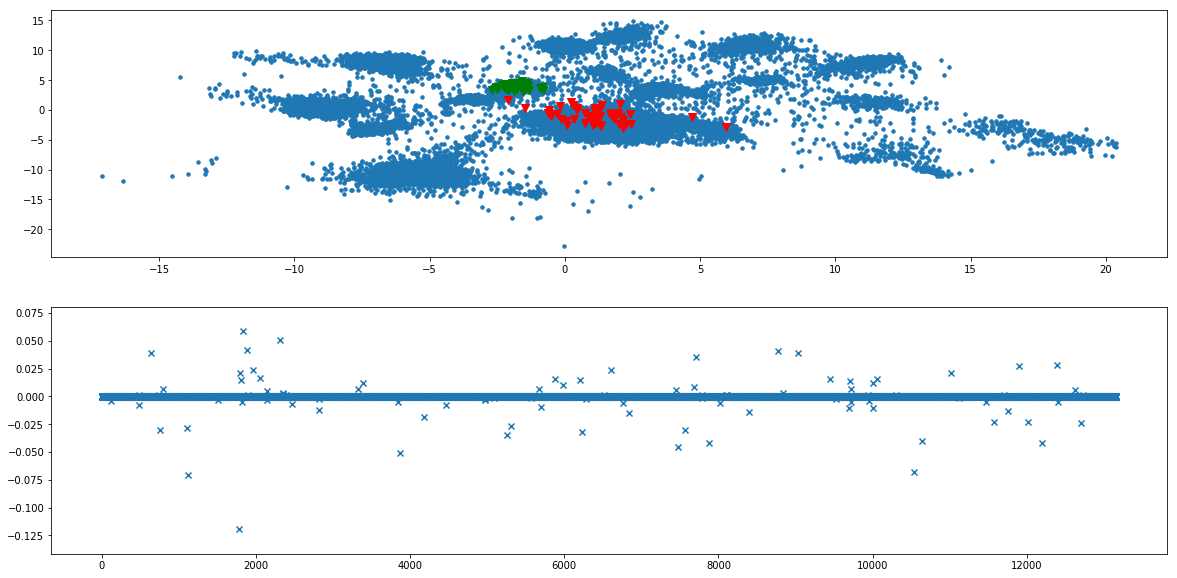


From  3  to  1 

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


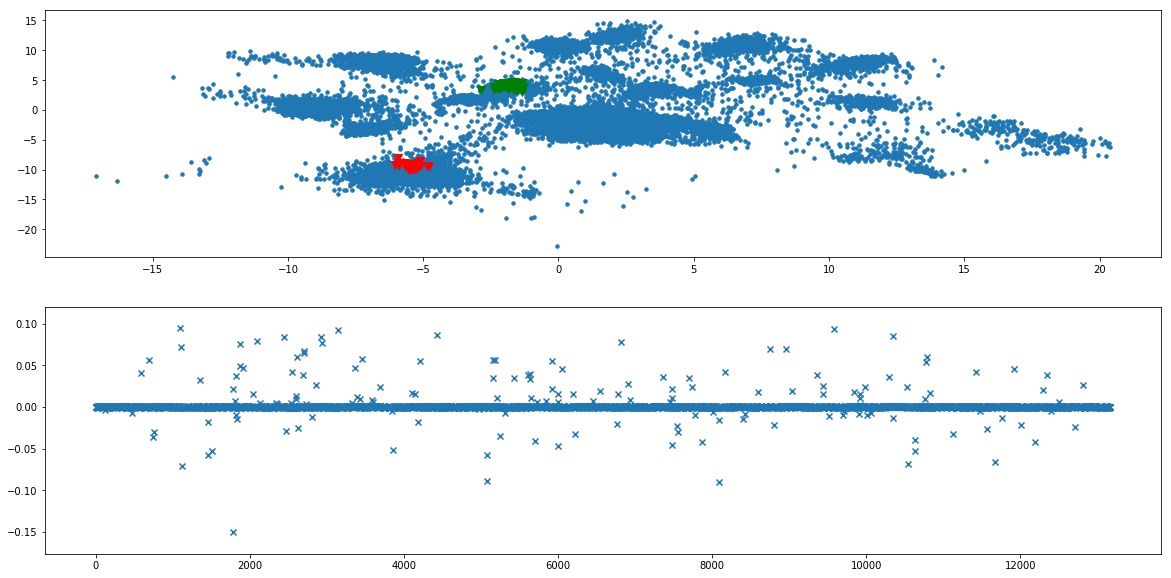


From  1  to  3 

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


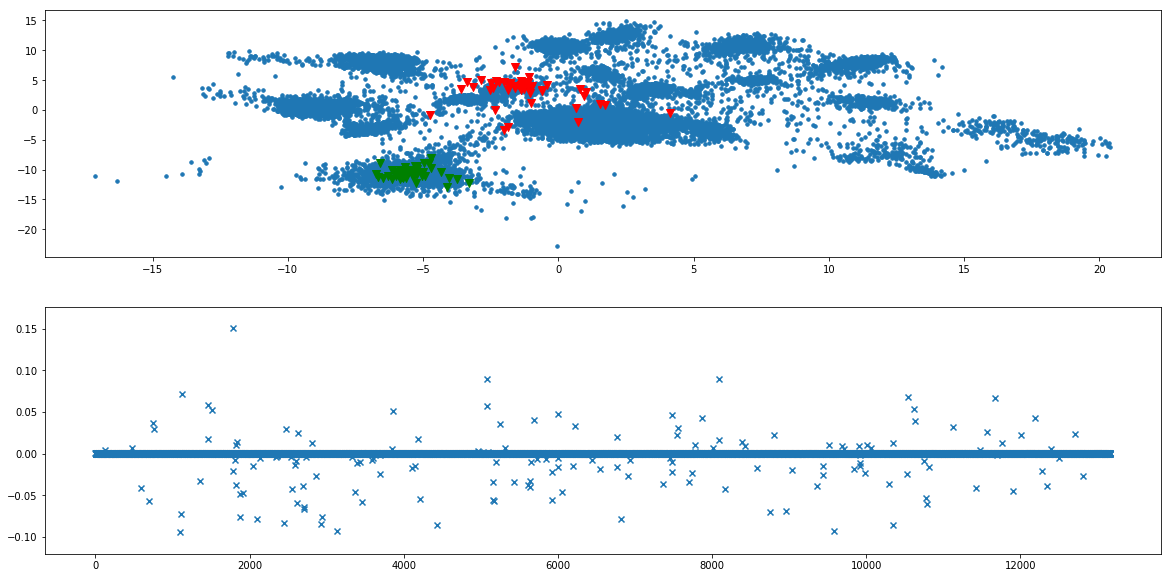

In [8]:
###
# Visualize the cluster explanations
###

def myplot(c1, c2):
    print("\nFrom ", c1, " to ", c2, "\n")
    
    if c1 == 0:
        d = deltas[c2 - 1]
    elif c2 == 0:
        d = -1.0 * deltas[c1 - 1]
    else:
        d = -1.0 * deltas[c1 - 1] + deltas[c2 - 1]
        
    apply(load_model, x_full, data_rep, indices, c1, np.reshape(d, (1, input_dim)))
    
myplot(0, 1)
myplot(1, 0)
myplot(0, 2)
myplot(2, 0)
myplot(1, 2)
myplot(2, 1)
myplot(0, 3)
myplot(3, 0)
myplot(3, 1)
myplot(1, 3)



 From 0 to 1

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


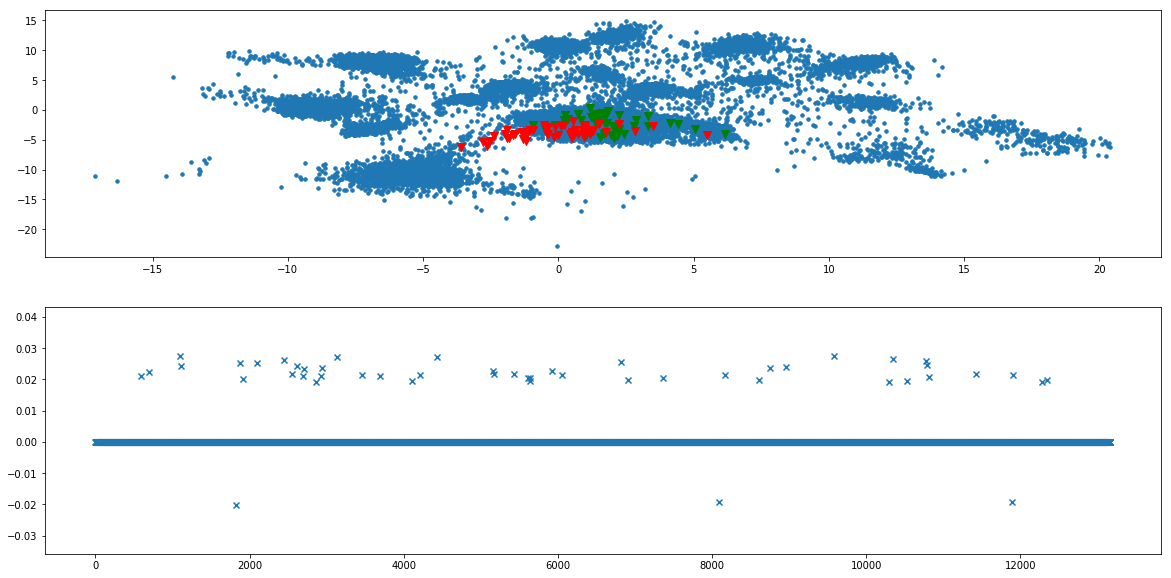


 From 1 to 0

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


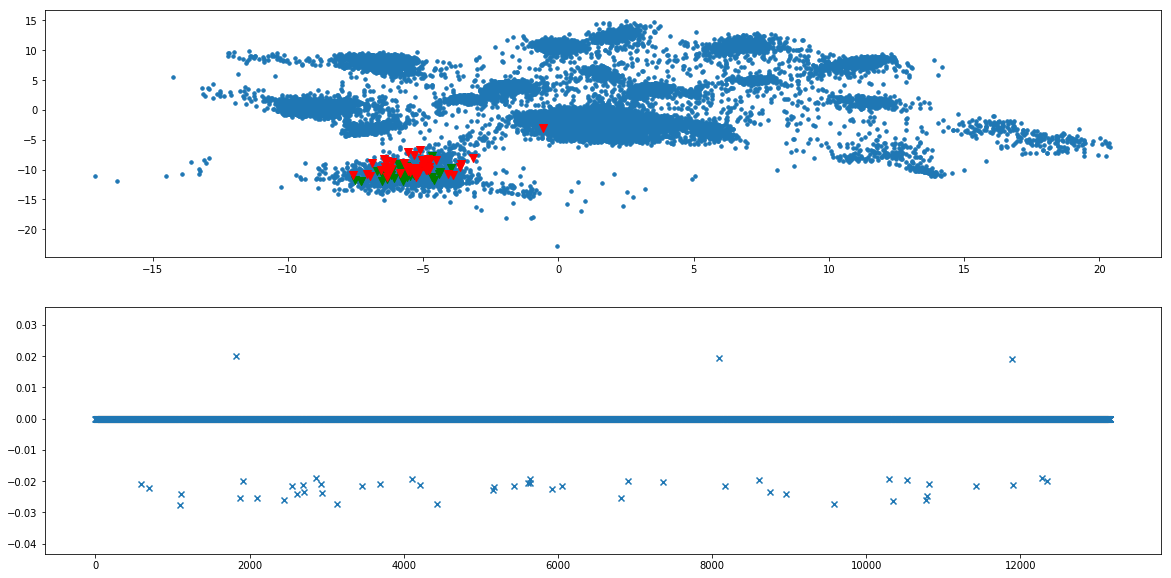


 From 0 to 2

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


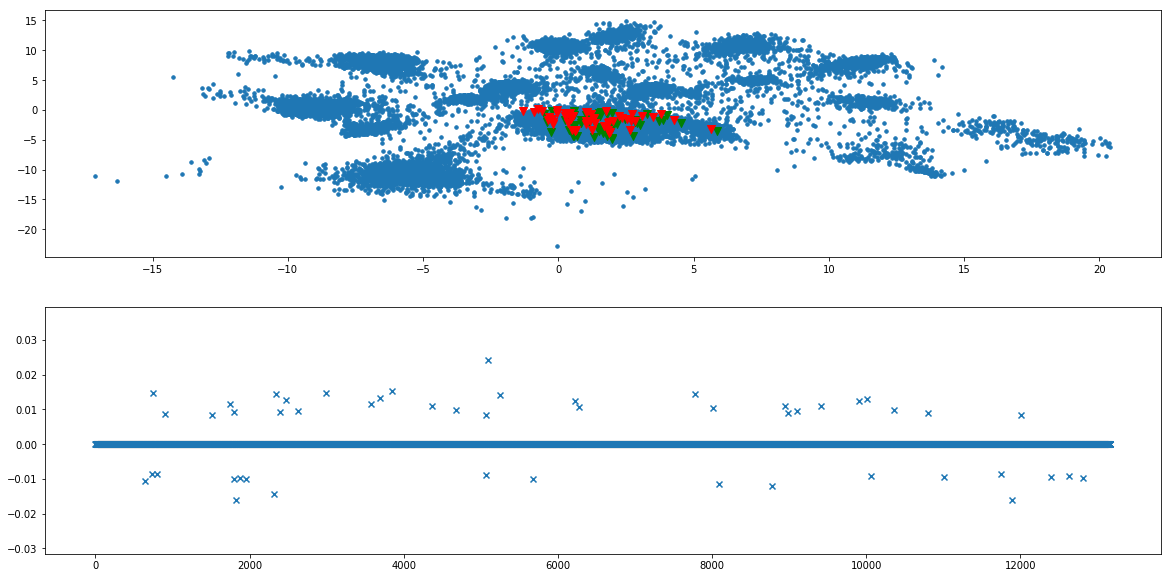


 From 2 to 0

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


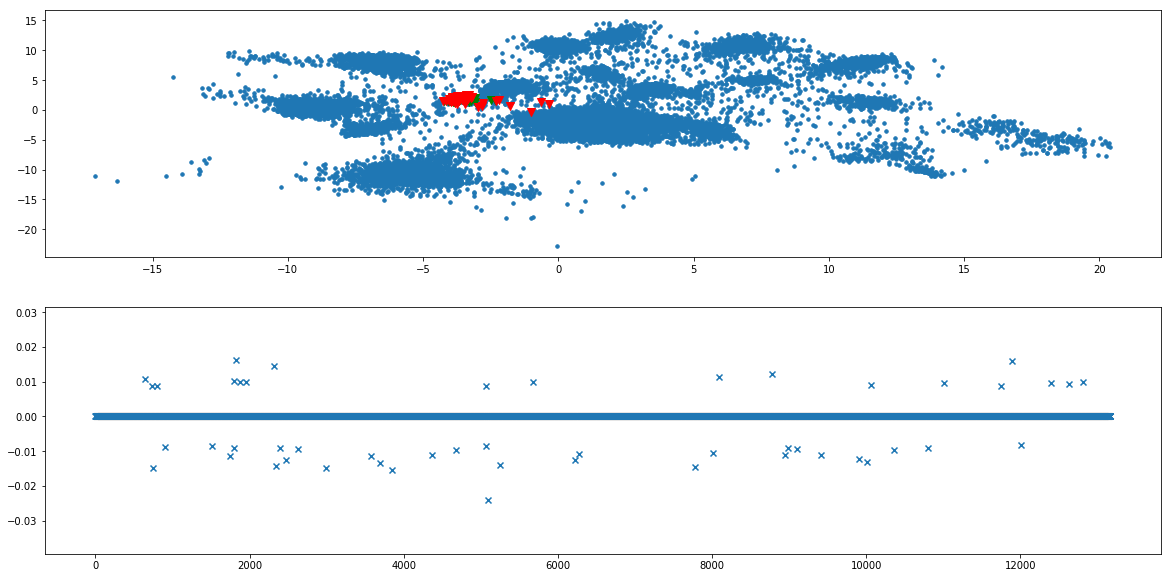


 From 1 to 2

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


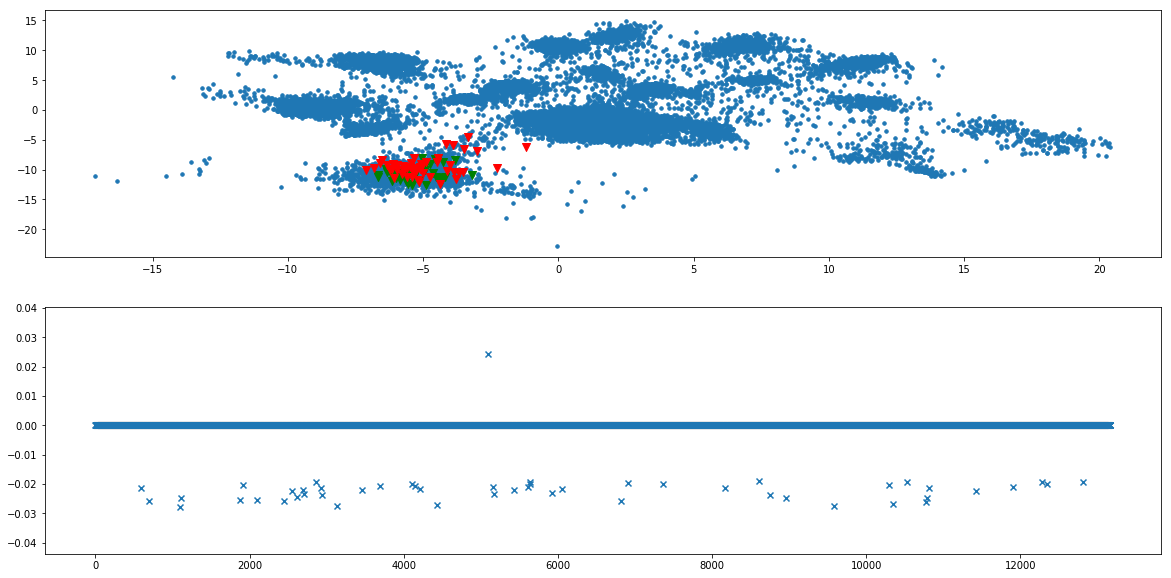


 From 2 to 1

INFO:tensorflow:Restoring parameters from Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


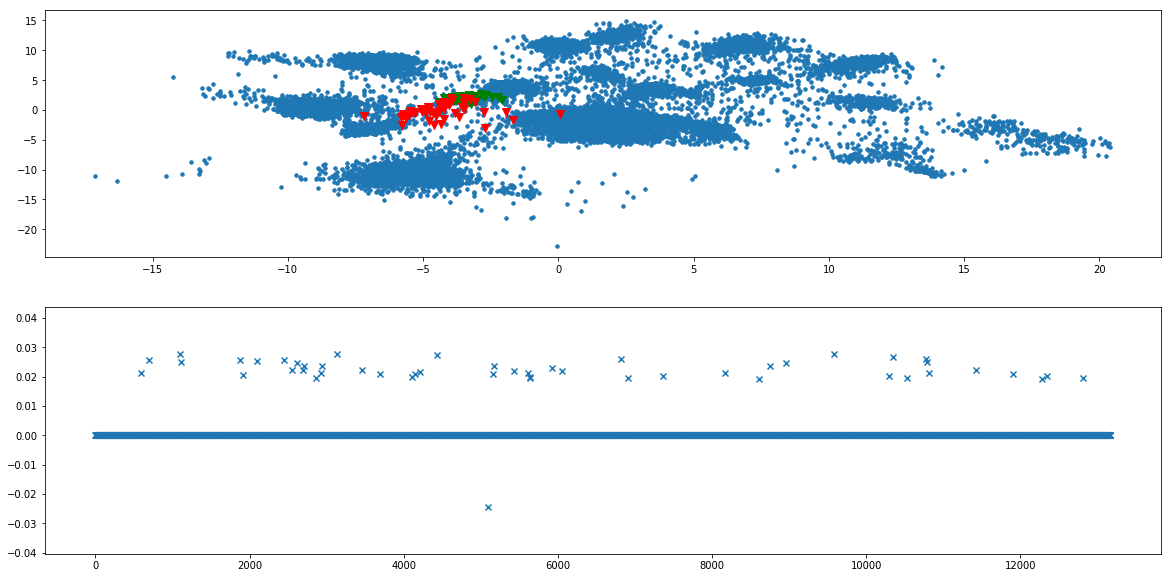

In [9]:
###
# Does the difference between the cluster means work as an explanation when it is limited to the K largest changes?
###

# No, it takes at least 200 features before they even begin to look ok

def truncate(values, k = 50):
    idx = (-np.abs(values)).argsort()[:k]
    values_aprox = np.zeros((values.shape[0]))
    values_aprox[idx] = values[idx]
    return values_aprox

def test_mean(load_model, x, y, indices, c1, c2, k = 50):
    r_c1 = np.mean(x[indices[c1]], axis = 0)
    r_c2 = np.mean(x[indices[c2]], axis = 0)
    diff = np.expand_dims(truncate(r_c2 - r_c1, k = k), 0)
    apply(load_model, x, y, indices, c1, diff)
    
print("\n From 0 to 1\n")
test_mean(load_model, x_full, data_rep, indices, 0, 1)

print("\n From 1 to 0\n")
test_mean(load_model, x_full, data_rep, indices, 1, 0)

print("\n From 0 to 2\n")
test_mean(load_model, x_full, data_rep, indices, 0, 2)

print("\n From 2 to 0\n")
test_mean(load_model, x_full, data_rep, indices, 2, 0)

print("\n From 1 to 2\n")
test_mean(load_model, x_full, data_rep, indices, 1, 2)

print("\n From 2 to 1\n")
test_mean(load_model, x_full, data_rep, indices, 2, 1)